In [1]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import sys
sys.path.append('..')

from src.controllers.pid_controller import PIDController

# Load baseline data
baseline = np.load('../data/simulation_results/baseline_data.npz')
time = baseline['time']
baseline_beta = baseline['beta_power']
mean_beta = baseline['mean_beta_power']

print("✅ Loaded baseline data")
print(f"   Mean beta power: {mean_beta:.4f}")
print(f"   Duration: {time[-1]:.2f} seconds")

✅ Loaded baseline data
   Mean beta power: 0.0366
   Duration: 10.00 seconds


In [2]:
# Cell 2: Set Control Parameters
# Target: Reduce beta power to 30% of baseline
TARGET_BETA = mean_beta * 0.3
SAMPLING_RATE = 1000  # Hz

print(f"🎯 Control Objective:")
print(f"   Baseline beta: {mean_beta:.4f}")
print(f"   Target beta: {TARGET_BETA:.4f}")
print(f"   Desired reduction: 70%")

🎯 Control Objective:
   Baseline beta: 0.0366
   Target beta: 0.0110
   Desired reduction: 70%


In [3]:
# Cell 3: Create Simplified Brain Model for Testing
# We need a simple model that responds to stimulation
class SimpleBrainModel:
    """
    Simplified brain model for controller testing
    Beta power decreases with stimulation
    """
    def __init__(self, baseline_beta, dt=0.001):
        self.beta = baseline_beta.copy()
        self.dt = dt
        self.time_idx = 0
        
    def step(self, stimulation):
        """Update brain state with stimulation"""
        if self.time_idx >= len(self.beta) - 1:
            return self.beta[-1]
        
        # Simple model: stimulation reduces beta with some dynamics
        # beta_new = beta_old - k1*stimulation + k2*noise
        current_beta = self.beta[self.time_idx]
        
        # Stimulation effect (reduces beta)
        stim_effect = stimulation * 0.05
        
        # Natural dynamics (oscillation)
        natural = self.beta[self.time_idx]
        
        # Add small noise
        noise = np.random.randn() * 0.01
        
        # Update
        new_beta = natural - stim_effect + noise
        new_beta = max(0.01, new_beta)  # Keep positive
        
        self.time_idx += 1
        return new_beta
    
    def reset(self):
        self.time_idx = 0

# Test the model
brain = SimpleBrainModel(baseline_beta)
print("✅ Brain model created")

✅ Brain model created


In [4]:
# Cell 4: Implement Closed-Loop Simulation
def run_closed_loop(controller, brain, target, duration_sec=10):
    """
    Run closed-loop control simulation
    
    Returns:
        time, beta_power, stimulation
    """
    dt = 0.001  # 1ms
    n_steps = int(duration_sec / dt)
    
    # Storage
    time_vec = np.zeros(n_steps)
    beta_vec = np.zeros(n_steps)
    stim_vec = np.zeros(n_steps)
    
    # Reset
    brain.reset()
    controller.reset()
    
    # Simulation loop
    for i in range(n_steps):
        # Measure current beta power
        current_beta = brain.step(stim_vec[i-1] if i > 0 else 0)
        
        # Compute control signal
        stim = controller.compute_control(current_beta, target)
        
        # Store
        time_vec[i] = i * dt
        beta_vec[i] = current_beta
        stim_vec[i] = stim
    
    return time_vec, beta_vec, stim_vec

print("✅ Closed-loop simulator ready")

✅ Closed-loop simulator ready


In [5]:
# Cell 5: Design PID Controller
# Start with conservative gains
pid = PIDController(
    kp=2.0,   # Proportional gain
    ki=0.5,   # Integral gain
    kd=0.1,   # Derivative gain
    dt=0.001,
    anti_windup=True,
    windup_limit=10.0
)

print("🎛️ PID Controller Created:")
print(f"   Kp = {pid.kp}")
print(f"   Ki = {pid.ki}")
print(f"   Kd = {pid.kd}")

🎛️ PID Controller Created:
   Kp = 2.0
   Ki = 0.5
   Kd = 0.1


In [6]:
# Cell 6: Run Closed-Loop Test
print("🚀 Running closed-loop simulation...")

# Create fresh brain model
brain = SimpleBrainModel(baseline_beta)

# Run simulation
time_cl, beta_cl, stim_cl = run_closed_loop(
    controller=pid,
    brain=brain,
    target=TARGET_BETA,
    duration_sec=10.0
)

# Calculate performance metrics
beta_reduction = (1 - np.mean(beta_cl[-5000:]) / mean_beta) * 100
settling_time = None
for i, b in enumerate(beta_cl):
    if abs(b - TARGET_BETA) < 0.1 * TARGET_BETA:
        settling_time = time_cl[i]
        break

print(f"\n✅ Simulation Complete!")
print(f"\n📊 Performance Metrics:")
print(f"   Beta reduction: {beta_reduction:.1f}%")
print(f"   Settling time: {settling_time:.2f}s" if settling_time else "   Settling time: >10s")
print(f"   Mean stimulation: {np.mean(stim_cl):.3f} mA")
print(f"   Max stimulation: {np.max(stim_cl):.3f} mA")

🚀 Running closed-loop simulation...

✅ Simulation Complete!

📊 Performance Metrics:
   Beta reduction: 42.0%
   Settling time: 0.00s
   Mean stimulation: 1.348 mA
   Max stimulation: 5.000 mA


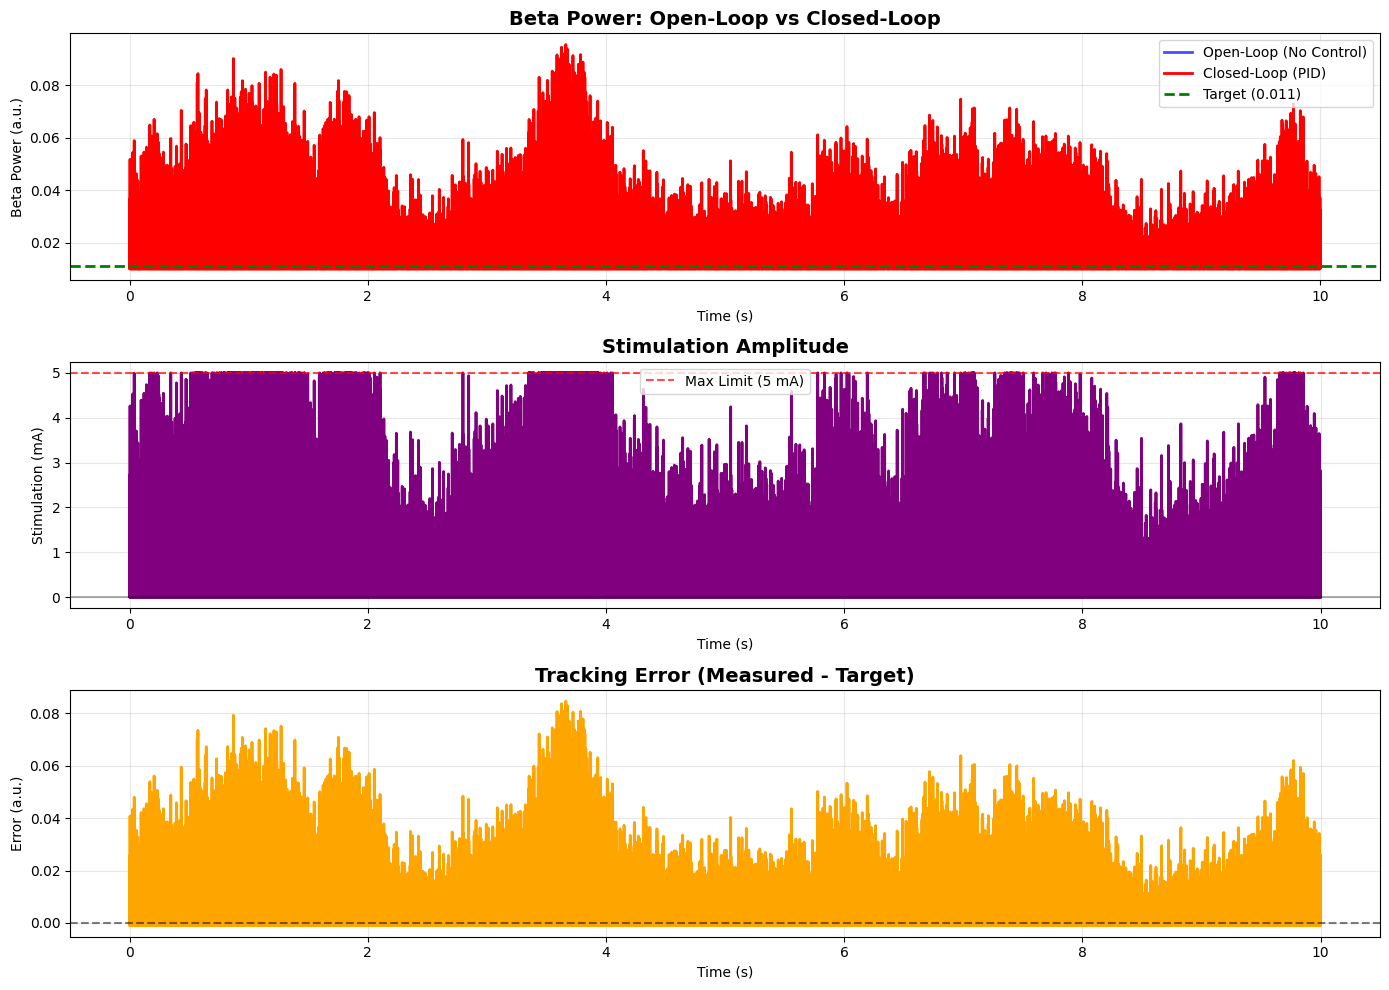

✅ Plots saved to data/simulation_results/


In [7]:
# Cell 7: Visualize Results
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Beta power comparison
axes[0].plot(time, baseline_beta, 'b-', alpha=0.7, linewidth=2, label='Open-Loop (No Control)')
axes[0].plot(time_cl, beta_cl, 'r-', linewidth=2, label='Closed-Loop (PID)')
axes[0].axhline(y=TARGET_BETA, color='g', linestyle='--', linewidth=2, label=f'Target ({TARGET_BETA:.3f})')
axes[0].set_title('Beta Power: Open-Loop vs Closed-Loop', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Beta Power (a.u.)')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Stimulation signal
axes[1].plot(time_cl, stim_cl, 'purple', linewidth=2)
axes[1].axhline(y=5.0, color='r', linestyle='--', alpha=0.7, label='Max Limit (5 mA)')
axes[1].axhline(y=0.0, color='k', linestyle='-', alpha=0.3)
axes[1].fill_between(time_cl, 0, stim_cl, alpha=0.3, color='purple')
axes[1].set_title('Stimulation Amplitude', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Stimulation (mA)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Error over time
error = beta_cl - TARGET_BETA
axes[2].plot(time_cl, error, 'orange', linewidth=2)
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[2].fill_between(time_cl, 0, error, alpha=0.3, color='orange')
axes[2].set_title('Tracking Error (Measured - Target)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Error (a.u.)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/simulation_results/pid_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plots saved to data/simulation_results/")

In [9]:
# Cell 8: Performance Summary
print("=" * 60)
print("PID CONTROLLER PERFORMANCE SUMMARY")
print("=" * 60)

print(f"\n🎯 Objective:")
print(f"   Reduce beta power from {mean_beta:.4f} to {TARGET_BETA:.4f}")

print(f"\n📊 Results:")
print(f"   Achieved beta: {np.mean(beta_cl[-5000:]):.4f}")
print(f"   Beta reduction: {beta_reduction:.1f}%")
print(f"   Settling time: {settling_time:.2f}s" if settling_time else "   Settling time: >10s")

print(f"\n⚡ Control Effort:")
print(f"   Mean stimulation: {np.mean(stim_cl):.3f} mA")
print(f"   Std stimulation: {np.std(stim_cl):.3f} mA")
print(f"   Max stimulation: {np.max(stim_cl):.3f} mA")

print(f"\n🛡️ Safety:")
violations = np.sum(stim_cl > 5.0) + np.sum(stim_cl < 0.0)
print(f"   Constraint violations: {violations}")

print("\n" + "=" * 60)

PID CONTROLLER PERFORMANCE SUMMARY

🎯 Objective:
   Reduce beta power from 0.0366 to 0.0110

📊 Results:
   Achieved beta: 0.0212
   Beta reduction: 42.0%
   Settling time: 0.00s

⚡ Control Effort:
   Mean stimulation: 1.348 mA
   Std stimulation: 1.712 mA
   Max stimulation: 5.000 mA

🛡️ Safety:
   Constraint violations: 0

